# Medyczne zastosowania uczenia maszynowego - zadanie 3

# Temat: Generowanie reguł i drzew decyzji

Analiza zbiorów danych dotyczących raka prostaty, zawierających próbki moczu, surowicy i tkanek

Katarzyna Pieczonka, nr indeksu 132785 <br/>
Informatyka II stopień, semestr zimowy <br/>
rok akademicki 2024/25

1. Wczytanie bibliotek i zbiorów danych

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.tree import plot_tree
from sklearn.feature_selection import SelectKBest, mutual_info_classif

In [2]:
#Odczytanie zbiorów danych
datasetM = pd.read_csv('FTIR_800-1800_mocz_1chory_0zdrowy.csv', delimiter=';', dtype=float, decimal=',') #Dane rozdzielone są średnikami
datasetS = pd.read_csv('FTIR_800-1800_surowica_1chory_0zdrowy.csv', delimiter=';', dtype=float, decimal=',')
datasetT = pd.read_csv('FTIR_800-1800_tkanka_1chory_0zdrowy.csv', delimiter=';', dtype=float, decimal=',')

noColumn1 = datasetM.shape[1]
noColumn2 = datasetS.shape[1]
noColumn3 = datasetT.shape[1]

print(f"Dataset1 - próbki moczu: \n\n {datasetM.head()}")
print(f"Dataset2 - próbki surowicy: \n\n {datasetS.head()}")
print(f"Dataset3 - próbki tkanek: \n\n {datasetT.head()}")

column_namesM = datasetM.columns[:-1] #Wszystkie nazwy kolumn w każdym ze zbiorów danych
column_namesS = datasetS.columns[:-1]
column_namesT = datasetT.columns[:-1]

Dataset1 - próbki moczu: 

    800.31372  800.79584  801.27796  801.76007  802.24219  802.72431  \
0    0.15608    0.15398    0.15202    0.15021    0.14849    0.14676   
1    0.18841    0.18582    0.18343    0.18128    0.17932    0.17746   
2    0.21911    0.21687    0.21493    0.21324    0.21162    0.20987   
3    0.12812    0.12601    0.12409    0.12236    0.12073    0.11910   
4    0.16763    0.16522    0.16306    0.16113    0.15932    0.15754   

   803.20642  803.68854  804.17066  804.65277  ...  1796.84919  1797.3313  \
0    0.14498    0.14316    0.14136    0.13965  ...     0.02749    0.02584   
1    0.17564    0.17384    0.17212    0.17054  ...     0.02380    0.02214   
2    0.20785    0.20556    0.20316    0.20084  ...     0.02588    0.02379   
3    0.11740    0.11562    0.11382    0.11209  ...     0.02655    0.02465   
4    0.15569    0.15379    0.15190    0.15012  ...     0.02583    0.02380   

   1797.81342  1798.29554  1798.77765  1799.25977  1799.74189  1800.224  \
0     0

2. Przygotowanie zbiorów danych - sprawdzanie brakujących wartości i usuwanie duplikatów.

In [3]:
#Sprawdzanie braków danych w dataset1
print("Liczba brakujących wartości dla poszczególnych kolumn w dataset1:")
missing_values = datasetM.isnull().sum()
for col, value in missing_values.items():
    if value != 0:
        print(f"{col}, brak: {value} wartości")

#Sprawdzanie duplikatów w dataset1
duplicates = datasetM.duplicated().sum()
print(f"Duplikaty: {duplicates}")
print("Usuwanie duplikatów: ")
datasetM = datasetM.drop_duplicates() #Funkcja usuwająca duplikaty
duplicates = datasetM.duplicated().sum()
print(f"Duplikaty: {duplicates}")

#####################################################

#Sprawdzanie braków danych w dataset2
print("Liczba brakujących wartości dla poszczególnych kolumn w dataset2:")
missing_values2 = datasetS.isnull().sum()
for col, value in missing_values2.items():
    if value != 0:
        print(f"{col}, brak: {value} wartości")

#Sprawdzanie duplikatów w dataset2
duplicates2 = datasetS.duplicated().sum()
print(f"Duplikaty: {duplicates2}")
print("Usuwanie duplikatów: ")
datasetS = datasetS.drop_duplicates()
duplicates2 = datasetS.duplicated().sum()
print(f"Duplikaty: {duplicates2}")

####################################################

#Sprawdzanie braków danych w dataset3
print("Liczba brakujących wartości dla poszczególnych kolumn w dataset3:")
missing_values3 = datasetT.isnull().sum()
for col, value in missing_values3.items():
    if value != 0:
        print(f"{col}, brak: {value} wartości")

#Sprawdzanie duplikatów w dataset3
duplicates3 = datasetT.duplicated().sum()
print(f"Duplikaty: {duplicates3}")
print("Usuwanie duplikatów: ")
datasetT = datasetT.drop_duplicates()
duplicates3 = datasetT.duplicated().sum()
print(f"Duplikaty: {duplicates3}")

Liczba brakujących wartości dla poszczególnych kolumn w dataset1:
Duplikaty: 2
Usuwanie duplikatów: 
Duplikaty: 0
Liczba brakujących wartości dla poszczególnych kolumn w dataset2:
Duplikaty: 0
Usuwanie duplikatów: 
Duplikaty: 0
Liczba brakujących wartości dla poszczególnych kolumn w dataset3:
Duplikaty: 2
Usuwanie duplikatów: 
Duplikaty: 0


# Podział na zbiór treningowy (80%), testowy (20%) - 5 foldów

In [4]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Funkcja do uczenia 

In [5]:
def analiza_zbioru(skf, dataset, features, labels, class_names):        
    accuracies = []

    #Iteracja przez poszczególne foldy i trenowanie modelu na każdym z nich
    for fold, (train_index, test_index) in enumerate(skf.split(features, labels), 1):
        #Podział na zbiór treningowy i testowy
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
    
        #Tworzenie nowej instancji modelu dla każdego folda
        model =  DecisionTreeClassifier(criterion="entropy",
                                   max_depth=5,
                                   min_samples_split=10,                                
                                   min_samples_leaf=10,
                                   max_leaf_nodes=30,
                                   min_impurity_decrease=0.02,
                                    random_state=42)
    
        # Trening drzewa decyzyjnego
        model.fit(X_train, y_train)
    
        # Generowanie predykcji dla zbioru testowego
        y_predicted = model.predict(X_test)
    
        #Policzenie jakości klasyfikacji przez porównanie: labels_predicted i labels_test 
        accuracy = accuracy_score(y_test, y_predicted)
        accuracies.append(accuracy)
        print(f"Fold {fold}: Dokładność = {accuracy:.4f}")
    
        # Wyświetlenie miar jakości
        print("\nRaport klasyfikacji:")
        print(classification_report(y_test, y_predicted, target_names=class_names))
        
        # Wyświetlenie macierzy pomyłek
        conf_matrix = confusion_matrix(y_test, y_predicted)
        print(f"Macierz pomyłek:\n{conf_matrix}")
    
        # Generowanie reguł decyzyjnych
        tree_rules = export_text(model, feature_names=dataset.columns[:-1].tolist())
        print(f"Reguły decyzyjne dla Fold {fold}:\n{tree_rules}")

        #Wybór 20% najbardziej istotnych cech do selekcji
        k = int(0.2 * features.shape[1])
        selector = SelectKBest(score_func=mutual_info_classif, k=k)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)
        
        print("Analiza zbioru  na podstawie zestawu 20% najbardziej istotnych cech: ")
        model.fit(X_train_selected, y_train)
        y_predicted = model.predict(X_test_selected)
        accuracy = accuracy_score(y_test, y_predicted)
        print(f"Dokładność dla zbioru c. selekcjonowanych = {accuracy:.4f}")
        print("----------------------------")
    
    # Wyświetlenie średniej i odchylenia standardowego dokładności
    print(f"\nŚrednia dokładność: {np.mean(accuracies):.4f}")
    print(f"Odchylenie standardowe dokładności: {np.std(accuracies):.4f}")
    
    #Zwracanie modelu, żeby można było użyć go potem do wizualnej reprezentacji drzewa decyzyjnego
    return model 

# Funkcja do wyznaczania reguł decyzyjnych wykorzystująca algorytm LEM2

In [21]:
def lem2(dataset):
    #Obliczamy uprzednio grupy dla każdej kolumny, aby zminimalizować liczbę operacji filtrowania i zoptymalizować czas wykonania
    column_groups = {
        column: {value: set(dataset[dataset[column] == value].index) for value in dataset[column].unique()}
        for column in dataset.columns[:-1]
    }
    
    rules = []
    decision_col = "Class"
    decisions = dataset["Class"].unique()
    
    for decision in decisions:
        target_set = set(dataset[dataset[decision_col] == decision].index)
    
        #Sprawdzanie, czy licznik nie wpadł w nieskończoną pętlę i przerywanie wykonania w takim przypadku
        iteration_count = 0
        while len(target_set) > 0:
            iteration_count += 1
            if iteration_count > 1000:
                print("Przekroczono limit iteracji.")
                break
    
            best_condition = None
            best_coverage = set()
    
            # Iteracja przez wcześniej obliczone grupy
            for column, groups in column_groups.items():
                for value, indices in groups.items():
                    coverage = indices & target_set  #Sprawdzanie pokrycia
                    if len(coverage) > len(best_coverage):
                        best_condition = (column, value)
                        best_coverage = coverage
    
            if not best_coverage:     #W przypadku jeśli nie znaleziono żadnego pokrycia, przerywamy pętlę, żeby nie wpaść w pętlę nieskończoną
                print("Brak pokrycia, kończenie pętli.")
                break
    
            # Tworzenie reguły
            rule = {"conditions": [best_condition], "decision": decision}
            rules.append(rule)
            target_set -= best_coverage  #Usuwamy pokryte obiekty

    return rules

# Zbiór1 - próbki moczu

In [7]:
#Podział cech i etykiet
featuresM = datasetM.iloc[:,:-1].values #cechy
labelsM = datasetM.iloc[:,-1].values #etykiety

class_names_ordered = sorted(np.unique(labelsM))
class_names = []
for i in range(0,len(class_names_ordered)):
    class_names.append(str(class_names_ordered[i]))

print("Analiza zbioru z próbkami moczu: ")
model = analiza_zbioru(skf, datasetM, featuresM, labelsM, class_names)

Analiza zbioru z próbkami moczu: 
Fold 1: Dokładność = 1.0000

Raport klasyfikacji:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        24
         1.0       1.00      1.00      1.00        32

    accuracy                           1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56

Macierz pomyłek:
[[24  0]
 [ 0 32]]
Reguły decyzyjne dla Fold 1:
|--- 1613.6448 <= 1.90
|   |--- 885.16628 <= 0.01
|   |   |--- class: 0.0
|   |--- 885.16628 >  0.01
|   |   |--- class: 0.0
|--- 1613.6448 >  1.90
|   |--- class: 1.0

Analiza zbioru  na podstawie zestawu 20% najbardziej istotnych cech: 
Dokładność dla zbioru c. selekcjonowanych = 1.0000
----------------------------
Fold 2: Dokładność = 1.0000

Raport klasyfikacji:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        24
         1.0       1.00      1.00      1.00   

[Text(0.5, 0.75, '955.07322 <= 1.901\nentropy = 0.988\nsamples = 100.0%\nvalue = [0.434, 0.566]\nclass = 1.0'),
 Text(0.25, 0.25, 'entropy = 0.083\nsamples = 43.9%\nvalue = [0.99, 0.01]\nclass = 0.0'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'entropy = 0.0\nsamples = 56.1%\nvalue = [0.0, 1.0]\nclass = 1.0'),
 Text(0.625, 0.5, '  False')]

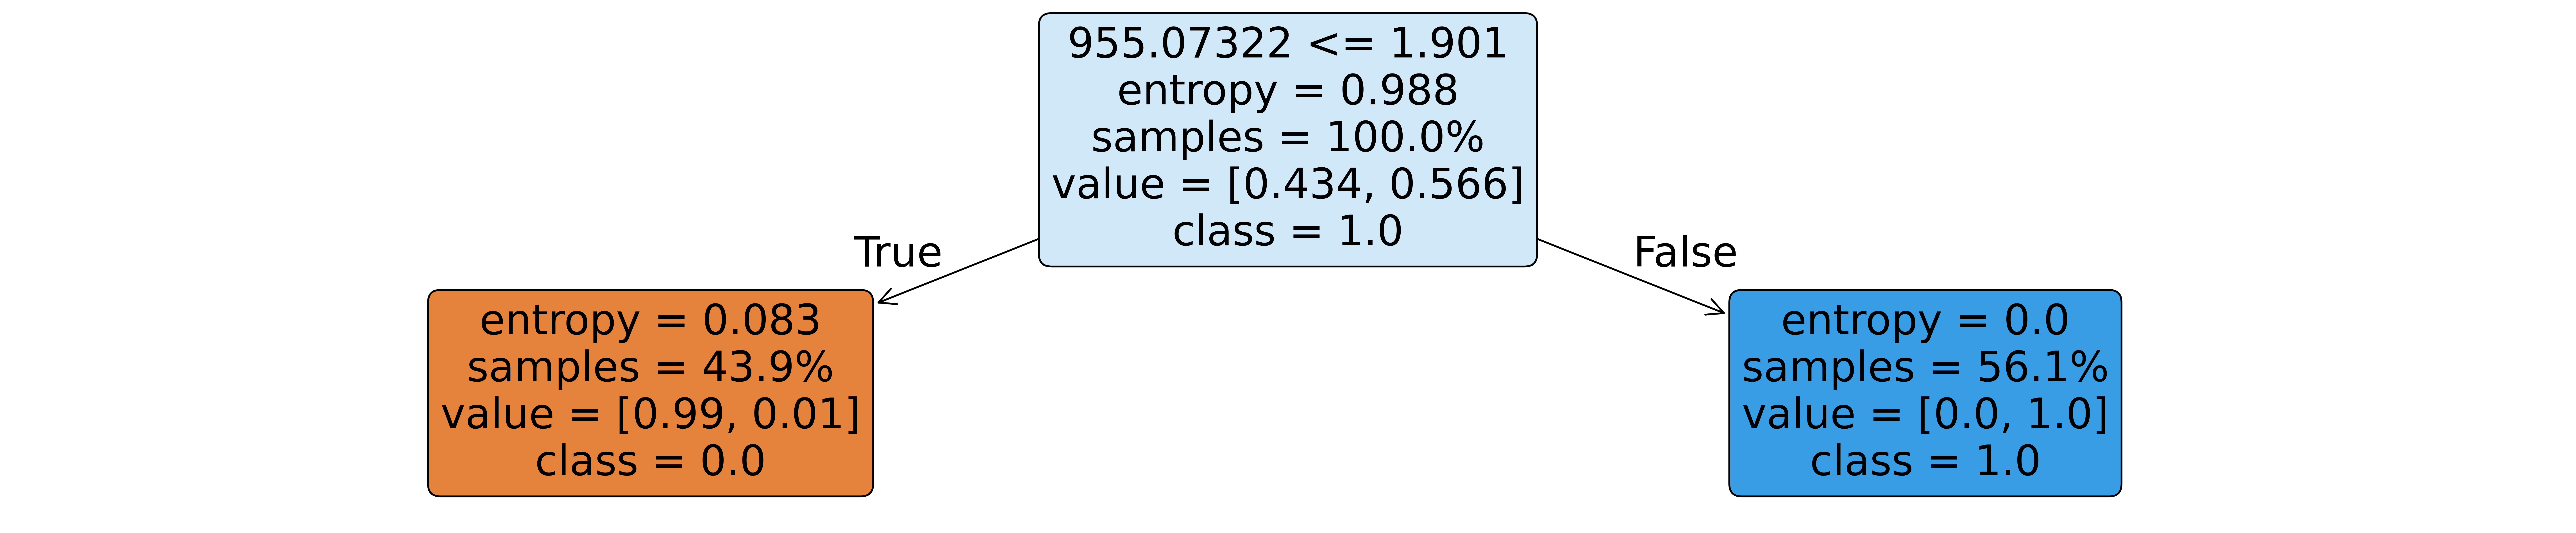

In [8]:
#Wizualna reprezentacja drzewa decyzyjnego
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (25,5), dpi = 600)
plot_tree(model, feature_names=datasetM.columns[:-1].tolist(), class_names=class_names, rounded=True, filled=True, proportion=True)

# Reguły decyzyjne - LEM2

In [22]:
#Ze względu na czas wykonania ilość kolumn branych pod uwagę podczas ustalania reguł 
#decyzyjnych została zmniejszona do 50
#Aby obliczyć reguły na całym zbiorze, wystarczy datasetM_subset podmienić na datasetM
datasetM_subset = pd.concat([datasetM.iloc[:, :50], datasetM.iloc[:, -1]], axis=1)

rules = lem2(datasetM_subset)

print("Reguły decyzyjne wygenerowane przez LEM2 dla zbioru próbek moczu:")
for rule in rules:
    print(f"Jeśli {rule['conditions']} to Decyzja = {rule['decision']}")


Reguły decyzyjne wygenerowane przez LEM2 dla zbioru próbek moczu:
Jeśli [('807.06336', np.float64(0.0))] to Decyzja = 0.0
Jeśli [('820.08051', np.float64(0.0))] to Decyzja = 0.0
Jeśli [('823.45533', np.float64(0.0))] to Decyzja = 0.0
Jeśli [('823.93745', np.float64(0.0))] to Decyzja = 0.0
Jeśli [('813.33088', np.float64(0.00867))] to Decyzja = 0.0
Jeśli [('822.4911', np.float64(0.00436))] to Decyzja = 0.0
Jeśli [('822.97321', np.float64(0.0))] to Decyzja = 0.0
Jeśli [('800.79584', np.float64(0.04144))] to Decyzja = 0.0
Jeśli [('801.76007', np.float64(0.04621))] to Decyzja = 0.0
Jeśli [('802.72431', np.float64(0.03532))] to Decyzja = 0.0
Jeśli [('802.72431', np.float64(0.04215))] to Decyzja = 0.0
Jeśli [('803.20642', np.float64(0.04059))] to Decyzja = 0.0
Jeśli [('803.20642', np.float64(0.04949))] to Decyzja = 0.0
Jeśli [('803.68854', np.float64(0.03084))] to Decyzja = 0.0
Jeśli [('804.65277', np.float64(0.0341))] to Decyzja = 0.0
Jeśli [('805.61701', np.float64(0.02619))] to Decyzja = 

# Zbiór2 - próbki surowicy

In [30]:
#Podział cech i etykiet
featuresS = datasetS.iloc[:,:-1].values #cechy
labelsS = datasetS.iloc[:,-1].values #etykiety

class_names_ordered = sorted(np.unique(labelsS))
class_names = []
for i in range(0,len(class_names_ordered)):
    class_names.append(str(class_names_ordered[i]))

print("Analiza zbioru z próbkami surowicy: ")
model = analiza_zbioru(skf, datasetS, featuresS, labelsS, class_names)

Analiza zbioru z próbkami surowicy: 
Fold 1: Dokładność = 0.9286

Raport klasyfikacji:
              precision    recall  f1-score   support

         0.0       0.95      0.88      0.91        24
         1.0       0.91      0.97      0.94        32

    accuracy                           0.93        56
   macro avg       0.93      0.92      0.93        56
weighted avg       0.93      0.93      0.93        56

Macierz pomyłek:
[[21  3]
 [ 1 31]]
Reguły decyzyjne dla Fold 1:
|--- 1635.82217 <= 2.00
|   |--- 1636.30429 <= 2.00
|   |   |--- 1631.96523 <= 2.00
|   |   |   |--- 1669.57035 <= 1.23
|   |   |   |   |--- 1078.49513 <= 0.37
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- 1078.49513 >  0.37
|   |   |   |   |   |--- class: 1.0
|   |   |   |--- 1669.57035 >  1.23
|   |   |   |   |--- class: 0.0
|   |   |--- 1631.96523 >  2.00
|   |   |   |--- class: 0.0
|   |--- 1636.30429 >  2.00
|   |   |--- class: 0.0
|--- 1635.82217 >  2.00
|   |--- class: 0.0

Analiza zbioru  na podst

[Text(0.7142857142857143, 0.9166666666666666, '969.53673 <= 1.999\nentropy = 0.988\nsamples = 100.0%\nvalue = [0.434, 0.566]\nclass = 1.0'),
 Text(0.5714285714285714, 0.75, '979.66118 <= 0.912\nentropy = 0.917\nsamples = 84.6%\nvalue = [0.332, 0.668]\nclass = 1.0'),
 Text(0.6428571428571428, 0.8333333333333333, 'True  '),
 Text(0.42857142857142855, 0.5833333333333334, '969.05461 <= 1.999\nentropy = 0.806\nsamples = 75.1%\nvalue = [0.247, 0.753]\nclass = 1.0'),
 Text(0.2857142857142857, 0.4166666666666667, '993.64257 <= 0.034\nentropy = 0.65\nsamples = 67.9%\nvalue = [0.167, 0.833]\nclass = 1.0'),
 Text(0.14285714285714285, 0.25, 'entropy = 0.0\nsamples = 16.3%\nvalue = [0.0, 1.0]\nclass = 1.0'),
 Text(0.42857142857142855, 0.25, '972.42943 <= 1.52\nentropy = 0.759\nsamples = 51.6%\nvalue = [0.219, 0.781]\nclass = 1.0'),
 Text(0.2857142857142857, 0.08333333333333333, 'entropy = 0.984\nsamples = 18.1%\nvalue = [0.425, 0.575]\nclass = 1.0'),
 Text(0.5714285714285714, 0.08333333333333333, '

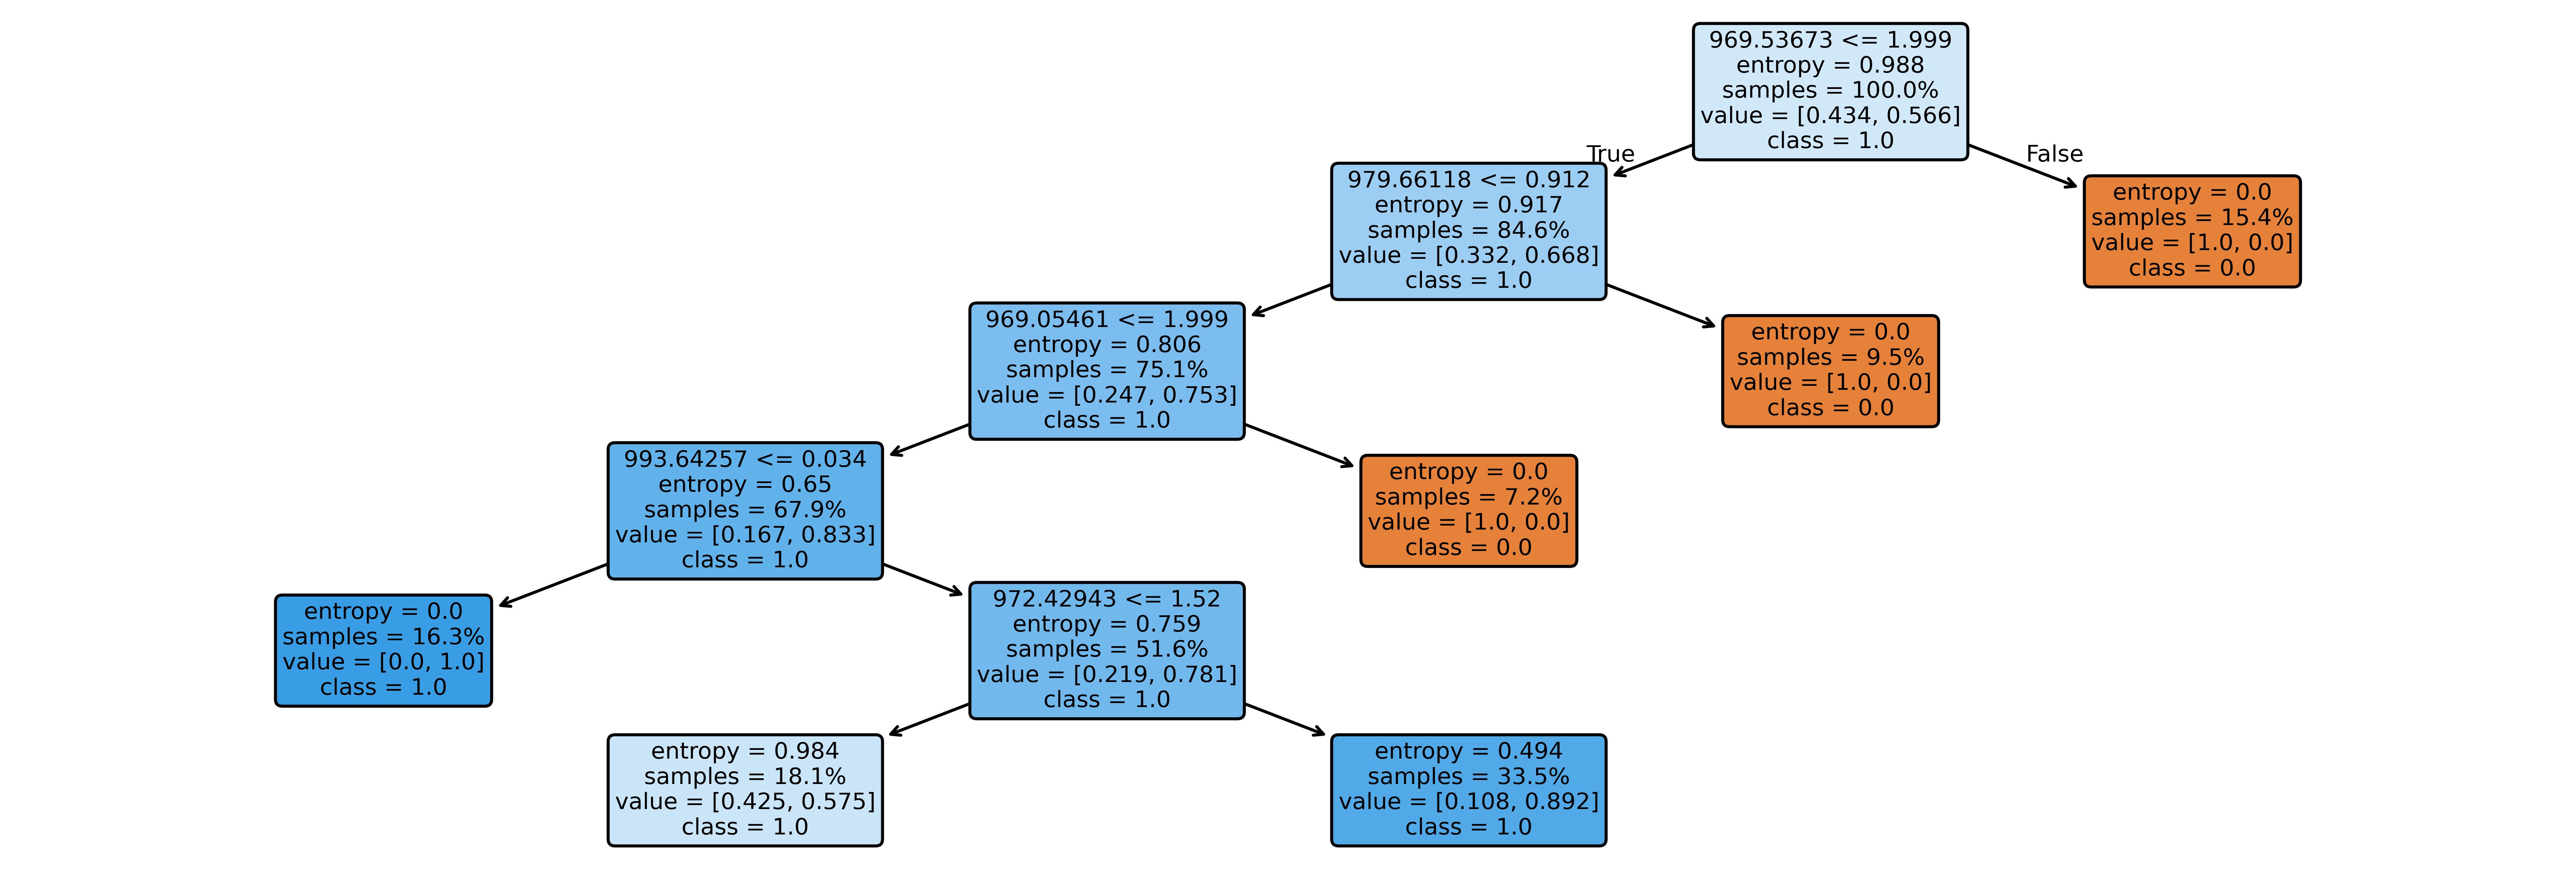

In [24]:
#Wizualna reprezentacja drzewa decyzyjnego
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (15,5), dpi = 600)
plot_tree(model, feature_names=datasetS.columns[:-1].tolist(), class_names=class_names, rounded=True, filled=True, proportion=True)

# Reguły decyzyjne - LEM2

In [25]:
#Ze względu na czas wykonania ilość kolumn branych pod uwagę podczas ustalania reguł 
#decyzyjnych została zmniejszona do 50
#Aby obliczyć reguły na całym zbiorze, wystarczy datasetM_subset podmienić na datasetM
datasetS_subset = pd.concat([datasetS.iloc[:, :50], datasetS.iloc[:, -1]], axis=1)

rules = lem2(datasetS_subset)            

print("Reguły decyzyjne wygenerowane przez LEM2 dla zbioru próbek surowicy:")
for rule in rules:
    print(f"Jeśli {rule['conditions']} to Decyzja = {rule['decision']}")

Reguły decyzyjne wygenerowane przez LEM2 dla zbioru próbek surowicy:
Jeśli [('804.17066', np.float64(0.02236))] to Decyzja = 0.0
Jeśli [('801.27796', np.float64(0.0426))] to Decyzja = 0.0
Jeśli [('801.27796', np.float64(0.03787))] to Decyzja = 0.0
Jeśli [('801.76007', np.float64(0.03059))] to Decyzja = 0.0
Jeśli [('802.72431', np.float64(0.06449))] to Decyzja = 0.0
Jeśli [('803.68854', np.float64(0.01007))] to Decyzja = 0.0
Jeśli [('804.65277', np.float64(0.02279))] to Decyzja = 0.0
Jeśli [('808.50971', np.float64(0.03527))] to Decyzja = 0.0
Jeśli [('810.43818', np.float64(0.02161))] to Decyzja = 0.0
Jeśli [('810.92029', np.float64(0.07744))] to Decyzja = 0.0
Jeśli [('812.84876', np.float64(0.00614))] to Decyzja = 0.0
Jeśli [('813.81299', np.float64(0.02692))] to Decyzja = 0.0
Jeśli [('814.29511', np.float64(0.03263))] to Decyzja = 0.0
Jeśli [('814.77723', np.float64(0.08578))] to Decyzja = 0.0
Jeśli [('815.25934', np.float64(0.03833))] to Decyzja = 0.0
Jeśli [('817.18781', np.float64(

# Zbiór3 - próbki tkanek

In [26]:
#Podział cech i etykiet
featuresT = datasetT.iloc[:,:-1].values #cechy
labelsT = datasetT.iloc[:,-1].values #etykiety

class_names_ordered = sorted(np.unique(labelsT))
class_names = []
for i in range(0,len(class_names_ordered)):
    class_names.append(str(class_names_ordered[i]))

print("Analiza zbioru z próbkami tkanek: ")
model = analiza_zbioru(skf, datasetT, featuresT, labelsT, class_names)


Analiza zbioru z próbkami tkanek: 
Fold 1: Dokładność = 0.9841

Raport klasyfikacji:
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98        32
         1.0       0.97      1.00      0.98        31

    accuracy                           0.98        63
   macro avg       0.98      0.98      0.98        63
weighted avg       0.98      0.98      0.98        63

Macierz pomyłek:
[[31  1]
 [ 0 31]]
Reguły decyzyjne dla Fold 1:
|--- 1673.42728 <= 0.70
|   |--- class: 0.0
|--- 1673.42728 >  0.70
|   |--- class: 1.0

Analiza zbioru  na podstawie zestawu 20% najbardziej istotnych cech: 
Dokładność dla zbioru c. selekcjonowanych = 1.0000
----------------------------
Fold 2: Dokładność = 1.0000

Raport klasyfikacji:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        32
         1.0       1.00      1.00      1.00        31

    accuracy                           1.00        63
   macro avg    

[Text(0.5, 0.75, '943.0203 <= 0.609\nentropy = 1.0\nsamples = 100.0%\nvalue = [0.5, 0.5]\nclass = 0.0'),
 Text(0.25, 0.25, 'entropy = 0.0\nsamples = 50.0%\nvalue = [1.0, 0.0]\nclass = 0.0'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'entropy = 0.0\nsamples = 50.0%\nvalue = [0.0, 1.0]\nclass = 1.0'),
 Text(0.625, 0.5, '  False')]

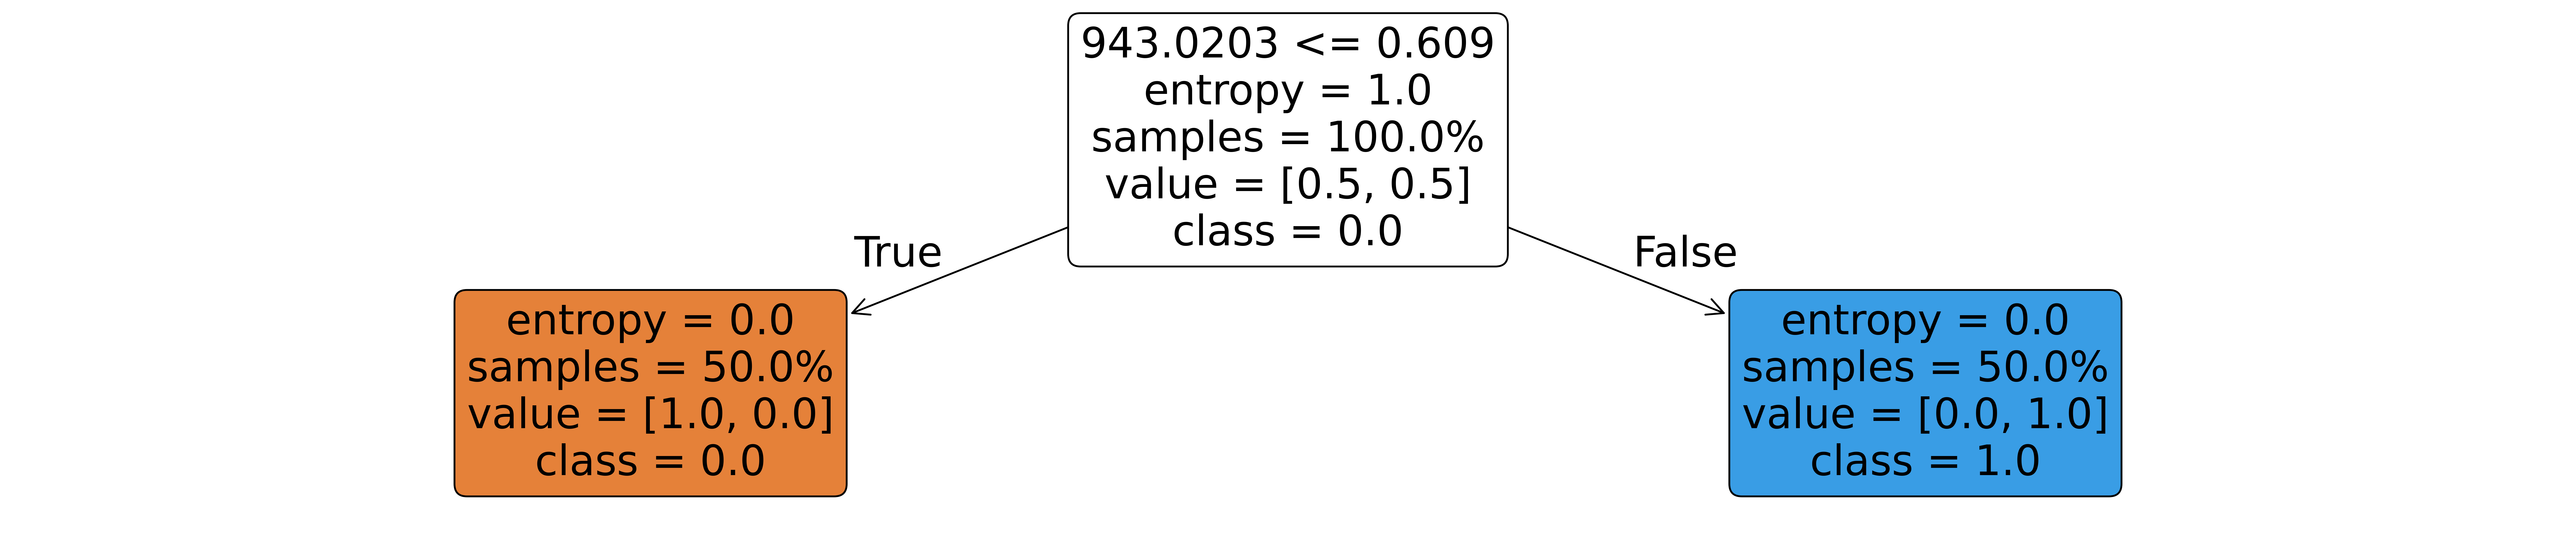

In [28]:
#Wizualna reprezentacja drzewa decyzyjnego
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (25,5), dpi = 600)
plot_tree(model, feature_names=datasetT.columns[:-1].tolist(), class_names=class_names, rounded=True, filled=True, proportion=True)

# Reguły decyzyjne - LEM2

In [29]:
#Ze względu na czas wykonania ilość kolumn branych pod uwagę podczas ustalania reguł 
#decyzyjnych została zmniejszona do 50
#Aby obliczyć reguły na całym zbiorze, wystarczy datasetM_subset podmienić na datasetM
datasetT_subset = pd.concat([datasetT.iloc[:, :50], datasetM.iloc[:, -1]], axis=1)

rules = lem2(datasetT_subset)            

print("Reguły decyzyjne wygenerowane przez LEM2 dla zbioru próbek tkanek:")
for rule in rules:
    print(f"Jeśli {rule['conditions']} to Decyzja = {rule['decision']}")

Brak pokrycia, kończenie pętli.
Reguły decyzyjne wygenerowane przez LEM2 dla zbioru próbek tkanek:
Jeśli [('822.97321', np.float64(0.02123))] to Decyzja = 0.0
Jeśli [('800.31372', np.float64(0.07538))] to Decyzja = 0.0
Jeśli [('800.31372', np.float64(0.0644))] to Decyzja = 0.0
Jeśli [('801.76007', np.float64(0.03829))] to Decyzja = 0.0
Jeśli [('801.76007', np.float64(0.04515))] to Decyzja = 0.0
Jeśli [('802.72431', np.float64(0.04102))] to Decyzja = 0.0
Jeśli [('802.72431', np.float64(0.05965))] to Decyzja = 0.0
Jeśli [('803.20642', np.float64(0.04345))] to Decyzja = 0.0
Jeśli [('803.20642', np.float64(0.05935))] to Decyzja = 0.0
Jeśli [('803.68854', np.float64(0.05786))] to Decyzja = 0.0
Jeśli [('803.68854', np.float64(0.05423))] to Decyzja = 0.0
Jeśli [('804.65277', np.float64(0.04812))] to Decyzja = 0.0
Jeśli [('804.65277', np.float64(0.04574))] to Decyzja = 0.0
Jeśli [('805.13489', np.float64(0.05502))] to Decyzja = 0.0
Jeśli [('806.58124', np.float64(0.0538))] to Decyzja = 0.0
Jeś

# Wnioski: 


Wnioski do analizy próbek moczu:
- Wysoka skuteczność - średnia dokładność modelu wynosi ok. 99%, z bardzo niskim odchyleniem standardowym 0.89%, co oznacza, że model działa skutecznie
- Nieznaczny spadek dokładności dla Foldu 3 i 5 wskazuje, że model dobrze generalizuje dla danych testowych
- Dla zredukowanego zbioru cech (20%) model nadal osiąga wysoką dokładność, wskazując, że za pomocą selekcji można zredukować zbędne dane, nie ryzykując utraty jakości modelu
- Reguły decyzyjne są proste do zinterpretowania. Opierają się w większości przypadków na kolumnie '1613.6449', która jest główną cechą decyzyjną, skutecznie rozdzielającą klasy

Wnioski do analizy próbek surowicy:
- Średnia dokładność modelu wynosi 87.66%, z odchyleniem standardowym wynoszącym 7.59%.
Wyniki wskazują na spadek skuteczności w porównaniu do analizy próbek moczu (gdzie dokładność wynosiła ~99%). Można to przypisać bardziej skomplikowanej strukturze danych lub większej nakładaniu się cech między klasami.
Fold 4 wykazuje najniższą dokładność (72.73%), co może sugerować nierównowagę danych w tym podziale lub bardziej skomplikowane relacje między cechami.
- Wygenerowane reguły decyzyjne są bardziej złożone niż w przypadku próbek moczu. Liczba warunków dla klasyfikacji wzrasta, co wskazuje, że dane surowicy mają większą różnorodność.
Reguły decyzyjne często opierają się na atrybutach takich jak: '1636.30429', '1635.82217', '1632.44735', '1680.65903'
- Średnia dokładność po selekcji cech spada do około 82%-83%, co wskazuje na pewną utratę informacji. Redukcja cech mogła usunąć kluczowe atrybuty, co wpłynęło na skuteczność klasyfikacji.

Wnioski do analizy próbek tkanek:
- Średnia dokładność modelu wynosi 99.68%, a odchylenie standardowe jest minimalne (0.63%). Oznacza to, że model działa bardzo stabilnie i jest niemal perfekcyjny w przewidywaniu klas.
- Reguły decyzyjne są wyjątkowo proste, opierają się niemal wyłącznie na jednej cesze: '1673.42728'. Sugeruje to, że próbki tkanek są możliwe do dobrego odseparowania za pomocą tej jednej kluczowej cechy.
- Po selekcji cech model osiąga 100% dokładności we wszystkich foldach, co oznacza, że pozostałe 80% cech nie wnosi dodatkowej informacji, jednak zbyt wysoki wynik może wskazywać na przeuczenie i powodować, że model nie będzie dobrze generalizował na danych testowych
- Ze względu na prostotę reguł i wysoką skuteczność klasyfikacji, model oparty na próbkach tkanek może być skutecznie wykorzystany w diagnostyce raka prostaty.